Loaded custom basis: {'RF': 'esbe', 'U1': 'esbe1', 'U2': 'esbe2', 'U3': 'esbe3', 'U4': 'esbe4', 'U5': 'esbe5', 'U6': 'esbe6', 'U7': 'esbe7'}
加载自定义Basis设置
self.unit_l= 0.001


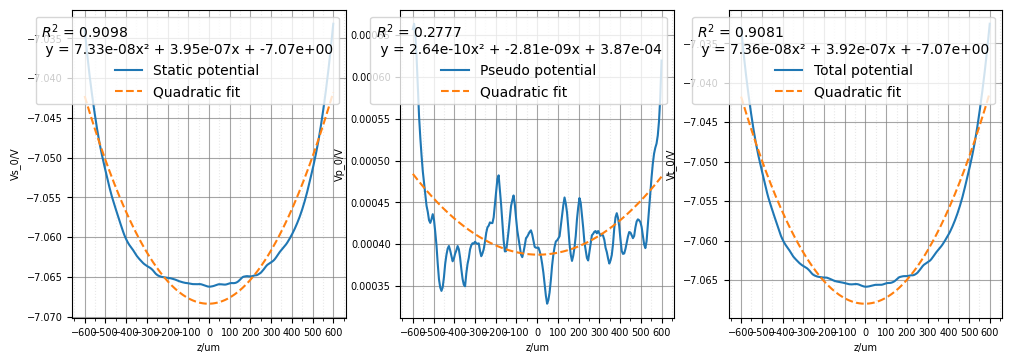

In [82]:
from configure import *

dirname = os.getcwd()
flag_smoothing=True #是否对导入的电势场格点数据做平滑化，如果True，那么平滑化函数默认按照下文def smoothing(data)
filename=os.path.join(dirname, "../../../data/monolithic20241118.csv") #文件名：导入的电势场格点数据
basis_filename=os.path.join(dirname, "electrode_basis.json")#文件名：自定义Basis设置 #可以理解为一种基矢变换，比如"U1"相当于电势场组合"esbe1"*0.5+"esbe1asy"*-0.5
basis = Data_Loader(filename, basis_filename, flag_smoothing)
basis.loadData()
configure = Configure(basis=basis)
# configure.load_from_file(os.path.join(dirname, "../saves/saved_config_regression_0.01_1000.json"))
configure.load_from_file(os.path.join(dirname, "../saves/saved_config_regression_0_10000_sym.json"))
Vs = configure.static_potential()
Vpp = configure.pseudo_potential()
Vt = Vs + Vpp


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

shape = Vt.shape
ls_label = ['x', 'y', 'z']

def R2(x,y):
    '''
    x: fit data
    y: raw data
    '''
    return 1-np.sum((x-y)**2)/np.sum((y-np.mean(y))**2)

def tf_scan(scan_id, ax_id, scan_loc=None, plot=False):
    '''
    scan_id: The direction of scan
    ax_id: The direction of trap freq
    scan_loc: The location of current scan
    '''
    id_list = [0, 1, 2]
    x = basis.coordinate_um[ax_id]
    if ax_id == scan_id:
        Vs_0 = np.take(np.take(Vs, [int(np.ceil(shape[(ax_id+1)%3]/2))], axis=(ax_id+1)%3), [int(np.ceil(shape[(ax_id+2)%3]/2))], axis=(ax_id+2)%3).flatten()
        Vp_0 = np.take(np.take(Vpp, [int(np.ceil(shape[(ax_id+1)%3]/2))], axis=(ax_id+1)%3), [int(np.ceil(shape[(ax_id+2)%3]/2))], axis=(ax_id+2)%3).flatten()
    else:
        id_list.remove(scan_id)
        id_list.remove(ax_id)
        left = id_list[0]
        Vs_0 = np.take(np.take(Vs, [scan_loc], axis=scan_id), [int(np.ceil(shape[left]/2))], axis=left).flatten()
        Vp_0 = np.take(np.take(Vpp, [scan_loc], axis=scan_id), [int(np.ceil(shape[left]/2))], axis=left).flatten()
    Vt_0 = Vs_0 + Vp_0
    ct = np.polyfit(x, Vt_0, 2)
    ta, tb, tc = ct
    if plot:
        fontsize = 7
        cs = np.polyfit(x, Vs_0, 2)
        sa, sb, sc = cs
        cp = np.polyfit(x, Vp_0, 2)
        pa, pb, pc = cp
        Vs_fit = np.polyval(cs, x)
        Vp_fit = np.polyval(cp, x)
        Vt_fit = np.polyval(ct, x)
        fig, ax = plt.subplots(1,3,figsize=(12,4))
        ax[0].plot(x, Vs_0,label='Static potential')
        ax[0].plot(x, Vs_fit,label='Quadratic fit', linestyle='--')
        ax[1].plot(x, Vp_0,label='Pseudo potential')
        ax[1].plot(x, Vp_fit,label='Quadratic fit', linestyle='--')
        ax[2].plot(x, Vt_0,label='Total potential')
        ax[2].plot(x, Vt_fit,label='Quadratic fit', linestyle='--')
        ax[0].set_xlabel('%s/um'%(ls_label[ax_id]), fontsize=fontsize)
        ax[0].set_ylabel('Vs_0/V', fontsize=fontsize)
        ax[0].tick_params(axis='x', labelsize=fontsize)
        ax[0].tick_params(axis='y', labelsize=fontsize)
        ax[0].legend(title=f'$R^2$ = {R2(Vs_fit, Vs_0):.4f}\n y = {sa:.2e}x² + {sb:.2e}x + {sc:.2e}')
        ax[1].set_xlabel('%s/um'%(ls_label[ax_id]), fontsize=fontsize)
        ax[1].set_ylabel('Vp_0/V', fontsize=fontsize)
        ax[1].tick_params(axis='x', labelsize=fontsize)
        ax[1].tick_params(axis='y', labelsize=fontsize)
        ax[1].legend(title=f'$R^2$ = {R2(Vp_fit, Vp_0):.4f} \n y = {pa:.2e}x² + {pb:.2e}x + {pc:.2e}')
        ax[2].set_xlabel('%s/um'%(ls_label[ax_id]), fontsize=fontsize)
        ax[2].set_ylabel('Vt_0/V', fontsize=fontsize)
        ax[2].tick_params(axis='x', labelsize=fontsize)
        ax[2].tick_params(axis='y', labelsize=fontsize)
        ax[2].legend(title=f'$R^2$ = {R2(Vt_fit, Vt_0):.4f} \n y = {ta:.2e}x² + {tb:.2e}x + {tc:.2e}')
        for i in range(3):
            ax[i].set_xticks(np.arange(-600, 700, 100))
            ax[i].xaxis.set_minor_locator(MultipleLocator(50))
            ax[i].grid(True, which='major', linestyle='-', color='gray', alpha=0.7)  # 主刻度网格
            ax[i].grid(True, which='minor', linestyle=':', color='lightgray', alpha=0.5)  # 次刻度网格
    return np.sqrt(2*ta/configure.m*configure.ec)
# consider wy in z direction

# ax_id, scan_id = 1, 2
ax_id = scan_id = 2
if ax_id == scan_id:
    tf_scan(scan_id, ax_id, plot=True)
else:
    wy = np.zeros(shape[scan_id])
    for z_id in range(shape[scan_id]):
        wy[z_id] = tf_scan(scan_id, ax_id, z_id)/(2*np.pi)
    plt.plot(basis.coordinate_um[scan_id], wy)
    plt.xlabel("%s/um"%ls_label[scan_id])
    plt.ylabel("f%s/MHz"%ls_label[ax_id])
    plt.xticks(np.arange(-600, 700, 100))
    plt.gca().xaxis.set_minor_locator(MultipleLocator(50))
    plt.grid(True, which='major', linestyle='-', color='gray', alpha=0.7)  # 主刻度网格
    plt.grid(True, which='minor', linestyle=':', color='lightgray', alpha=0.5)  # 次刻度网格
    plt.show()

In [36]:
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
import psutil

with ProcessPoolExecutor() as executor:
    max_workers = executor._max_workers
    print(f"最大并行进程数: {max_workers}")
    parent = psutil.Process()  # 当前 Python 进程
    children = parent.children(recursive=True)  # 获取所有子进程
    print(f"当前运行的子进程数 by psutil: {len(children)}")
    time.sleep(0.1)  # 短暂等待以确保子进程启动
    active_processes = len(multiprocessing.active_children())
    print(f"当前活跃进程数 by multiprocessing: {active_processes}")

最大并行进程数: 208
当前运行的子进程数 by psutil: 0
当前活跃进程数 by multiprocessing: 0
